In [11]:
%pip install torch pandas numpy matplotlib scikit-learn seaborn ucimlrepo shap xgboost

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, r2_score
from torch.utils.data import DataLoader, TensorDataset

# Configuració global
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cpu")

print("Entorn preparat per a Distil·lació.")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Entorn preparat per a Distil·lació.


In [12]:
print("Descarregant dataset UCI Credit Card...")
dataset = fetch_ucirepo(id=350)
X_raw = dataset.data.features
y_raw = dataset.data.targets

# --- PRE-PROCESSAMENT ---
financial_cols = ['X12', 'X13', 'X14', 'X15', 'X16', 'X17', 
                  'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
X_processed = X_raw.copy()

print("Aplicant Log1p...")
for col in financial_cols:
    col_data = X_processed[col].values
    X_processed[col] = np.sign(col_data) * np.log1p(np.abs(col_data))

X_np = X_processed.values.astype(np.float32)
y_np = y_raw.values.astype(np.float32).ravel()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"Dades llestes. Train: {X_train_scaled.shape}")

Descarregant dataset UCI Credit Card...


KeyboardInterrupt: 

In [ ]:
print("1. Entrenant el Mestre (XGBoost)...")
# Entrenem un model fort per tenir bona accuracy
teacher_model = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=4, 
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
teacher_model.fit(X_train_scaled, y_train)

# Validem el mestre
y_pred_teacher = teacher_model.predict_proba(X_test_scaled)[:, 1]
auc_teacher = roc_auc_score(y_test, y_pred_teacher)
print(f"   Teacher AUC: {auc_teacher:.4f}")

print("\n2. Generant 'Ground Truth' SHAP (Això pot trigar uns segons)...")
# TreeExplainer és molt ràpid
explainer = shap.TreeExplainer(teacher_model)

# Calculem SHAP per a Train i Test
# L'alumne necessita els SHAP del Train per aprendre
shap_values_train = explainer.shap_values(X_train_scaled)
shap_values_test = explainer.shap_values(X_test_scaled)

print(f"Dataset d'Explicacions creat. Shape: {shap_values_train.shape}")

1. Entrenant el Mestre (XGBoost)...
   Teacher AUC: 0.7778

2. Generant 'Ground Truth' SHAP (Això pot trigar uns segons)...
Dataset d'Explicacions creat. Shape: (24000, 23)


In [ ]:
class FastStudentXAI(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        # Backbone comú (molt lleuger per ser ràpid)
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Capçal 1: Predicció de Risc (Binary Classification)
        self.risk_head = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
        # Capçal 2: Predicció d'Explicació (Regression Vector)
        # Prediu els 23 valors SHAP directament
        self.explanation_head = nn.Sequential(
            nn.Linear(32, output_dim) 
            # Sense activació perquè els SHAP values poden ser +/- i no tenen límit
        )

    def forward(self, x):
        features = self.backbone(x)
        risk = self.risk_head(features)
        explanation = self.explanation_head(features)
        return risk, explanation

# Preparem DataLoaders que incloguin els valors SHAP com a target
# Inputs: X
# Targets: (y_label, shap_values)
train_ds = TensorDataset(
    torch.tensor(X_train_scaled), 
    torch.tensor(y_train).float().unsqueeze(1),
    torch.tensor(shap_values_train).float()
)
test_ds = TensorDataset(
    torch.tensor(X_test_scaled), 
    torch.tensor(y_test).float().unsqueeze(1),
    torch.tensor(shap_values_test).float()
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
# Batch 1 per simular temps real al test
test_loader_rt = DataLoader(test_ds, batch_size=1, shuffle=False)

student = FastStudentXAI(input_dim=23, output_dim=23)
print("✅ Alumne inicialitzat (Dual-Head Architecture).")

✅ Alumne inicialitzat (Dual-Head Architecture).


In [ ]:
# Pèrdues
criterion_risk = nn.BCELoss()      # Per encertar el default
criterion_expl = nn.MSELoss()      # Per clavar els valors SHAP

optimizer = optim.Adam(student.parameters(), lr=0.001)
epochs = 50

# Pes de la pèrdua d'explicació (Alpha)
# Si és alt, prioritza explicar bé. Si és baix, prioritza predir bé.
alpha = 10.0 

print(f"Iniciant Distil·lació (Alpha={alpha})...")
student.train()

history = {'loss': [], 'risk_loss': [], 'expl_loss': []}

for epoch in range(epochs):
    total_loss = 0
    
    for batch_x, batch_y, batch_shap in train_loader:
        optimizer.zero_grad()
        
        pred_risk, pred_expl = student(batch_x)
        
        loss_r = criterion_risk(pred_risk, batch_y)
        loss_e = criterion_expl(pred_expl, batch_shap)
        
        # Loss combinada
        loss = loss_r + alpha * loss_e
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        student.eval()
        with torch.no_grad():
            p_r, p_e = student(torch.tensor(X_test_scaled))
            auc = roc_auc_score(y_test, p_r.numpy())
            # R2 Score per veure com de bé imitem els SHAP values
            r2_expl = r2_score(shap_values_test, p_e.numpy())
            
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | "
              f"Student AUC: {auc:.4f} | SHAP Fidelity (R2): {r2_expl:.4f}")
        student.train()

print("✅ Distil·lació completada.")

Iniciant Distil·lació (Alpha=10.0)...
Epoch 10/50 | Loss: 0.4429 | Student AUC: 0.7727 | SHAP Fidelity (R2): 0.6744
Epoch 20/50 | Loss: 0.4344 | Student AUC: 0.7705 | SHAP Fidelity (R2): 0.6885
Epoch 30/50 | Loss: 0.4282 | Student AUC: 0.7743 | SHAP Fidelity (R2): 0.6889
Epoch 40/50 | Loss: 0.4240 | Student AUC: 0.7702 | SHAP Fidelity (R2): 0.6939
Epoch 50/50 | Loss: 0.4196 | Student AUC: 0.7702 | SHAP Fidelity (R2): 0.6955
✅ Distil·lació completada.


 AVALUACIÓ ESTADÍSTICA DEL MODEL STUDENT

1. MÈTRIQUES DE CLASSIFICACIÓ:
------------------------------
                precision    recall  f1-score   support

No Default (0)       0.84      0.94      0.89      4673
   Default (1)       0.64      0.39      0.49      1327

      accuracy                           0.82      6000
     macro avg       0.74      0.66      0.69      6000
  weighted avg       0.80      0.82      0.80      6000

 AUC-ROC Score: 0.7702


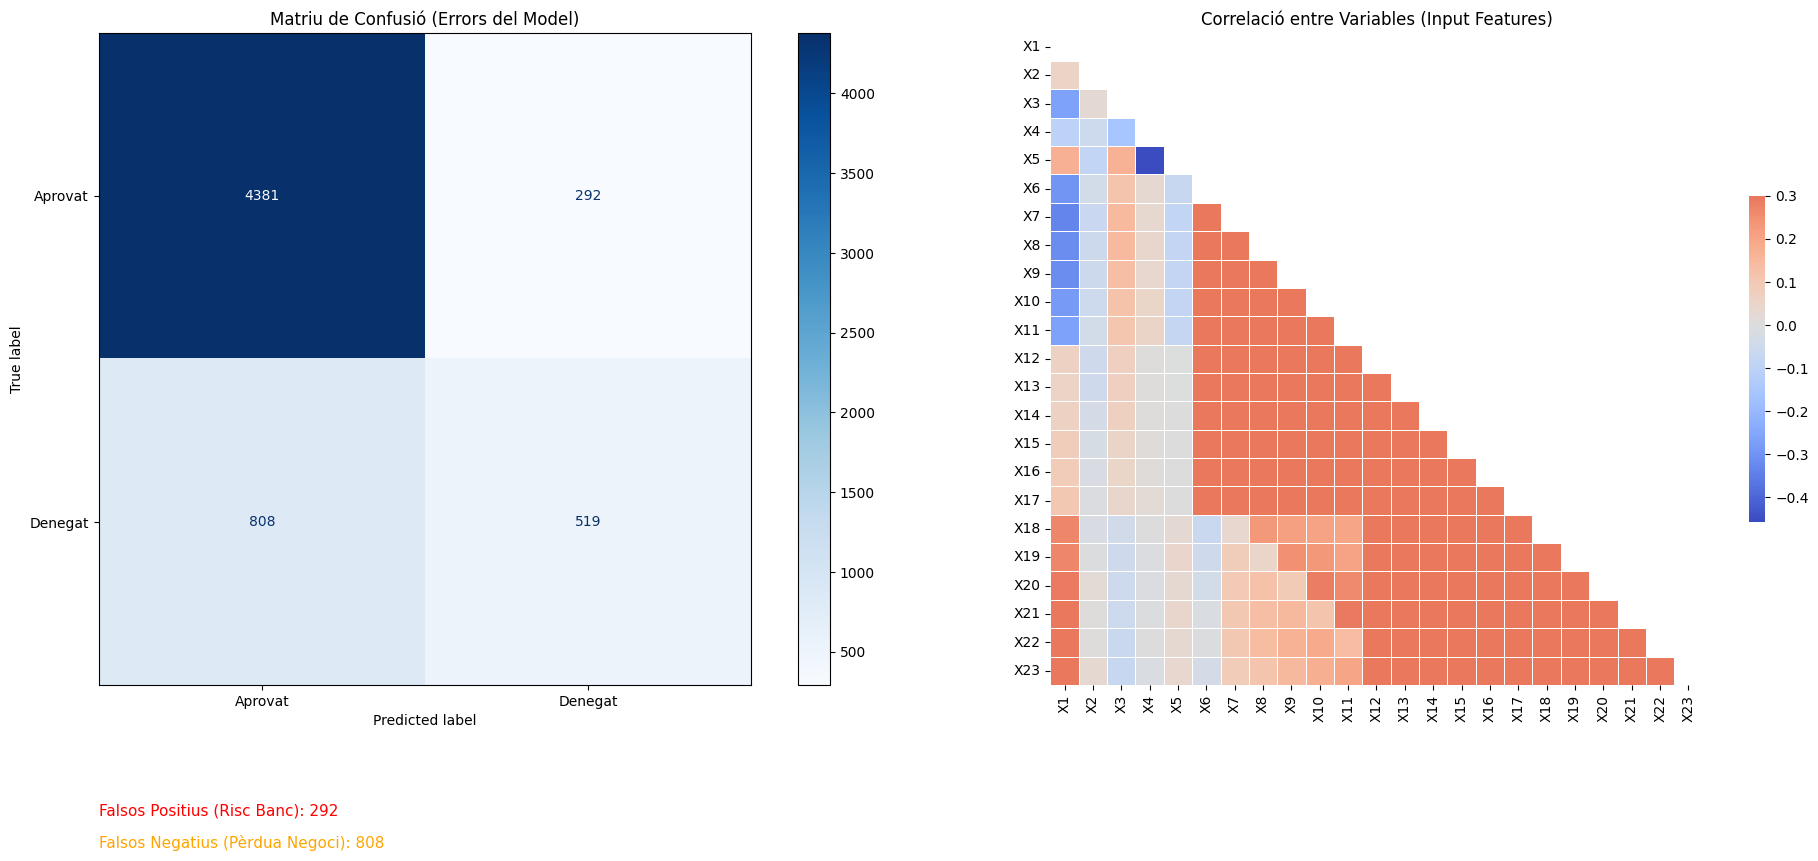

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay

def comprehensive_evaluation(student_model, X_test_tensor, y_test, feature_names):
    print(" AVALUACIÓ ESTADÍSTICA DEL MODEL STUDENT")
    print("=" * 60)
    
    # 1. Obtenció de Prediccions
    student_model.eval()
    with torch.no_grad():
        # Recorda: Student retorna (risc, explicació). Volem risc [0].
        risks, _ = student_model(torch.tensor(X_test_tensor).float())
        probs = risks.numpy().flatten()
        preds = (probs > 0.5).astype(int)
    
    # 2. Mètriques Estàndard
    print("\n1. MÈTRIQUES DE CLASSIFICACIÓ:")
    print("-" * 30)
    print(classification_report(y_test, preds, target_names=['No Default (0)', 'Default (1)']))
    
    auc = roc_auc_score(y_test, probs)
    print(f" AUC-ROC Score: {auc:.4f}")
    
    # 3. Visualització Gràfica (2 Plots)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # --- Plot A: Matriu de Confusió ---
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Aprovat', 'Denegat'])
    disp.plot(cmap='Blues', ax=axes[0], values_format='d')
    axes[0].set_title('Matriu de Confusió (Errors del Model)')
    
    # Annotacions extra per al paper
    tn, fp, fn, tp = cm.ravel()
    axes[0].text(0, -0.2, f"Falsos Positius (Risc Banc): {fp}", transform=axes[0].transAxes, fontsize=11, color='red')
    axes[0].text(0, -0.25, f"Falsos Negatius (Pèrdua Negoci): {fn}", transform=axes[0].transAxes, fontsize=11, color='orange')

    # --- Plot B: Matriu de Correlacions ---
    # Creem un DataFrame temporal per calcular correlacions
    df_test = pd.DataFrame(X_test_tensor, columns=feature_names)
    
    # Calculem la matriu de correlació de Spearman (no lineal)
    corr_matrix = df_test.corr(method='spearman')
    
    # Fem servir una màscara per veure només la meitat inferior (més net)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[1])
    axes[1].set_title('Correlació entre Variables (Input Features)')
    
    plt.tight_layout()
    plt.show()

# --- EXECUCIÓ ---
# Assegura't de passar X_test_scaled (numpy array)
comprehensive_evaluation(student, X_test_scaled, y_test, list(dataset.data.features.columns))


1. TEST DE LATÈNCIA (Temps Real)
------------------------------
Latència P99: 0.033 ms
Speedup vs SHAP (aprox 500ms): 15064x més ràpid

2. TEST DE FIDELITAT VISUAL


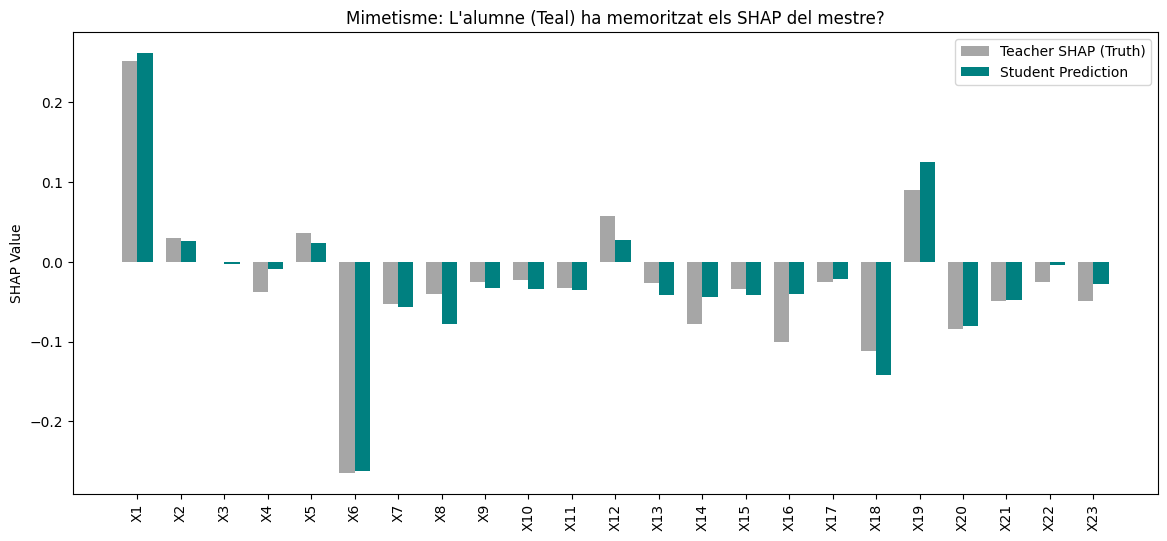

In [ ]:
import time

# 1. Test de Latència
latencies = []
student.eval()
print("\n1. TEST DE LATÈNCIA (Temps Real)")
print("-" * 30)

with torch.no_grad():
    for i, (bx, _, _) in enumerate(test_loader_rt):
        if i >= 1000: break
        start = time.perf_counter()
        # En un sol forward pass obtenim predicció I explicació
        _ = student(bx)
        latencies.append((time.perf_counter() - start) * 1000)

p99 = np.percentile(latencies, 99)
print(f"Latència P99: {p99:.3f} ms")
print(f"Speedup vs SHAP (aprox 500ms): {500/p99:.0f}x més ràpid")

# 2. Test de Fidelitat Visual
print("\n2. TEST DE FIDELITAT VISUAL")
idx = 0 # Primer client del test
x_in = torch.tensor(X_test_scaled[idx:idx+1])

# Predicció Student
risk_s, shap_s = student(x_in)
shap_s = shap_s.detach().numpy().flatten()

# Ground Truth (Teacher SHAP)
shap_t = shap_values_test[idx]

# Plot
features = list(X_raw.columns)
x_pos = np.arange(len(features))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x_pos - width/2, shap_t, width, label='Teacher SHAP (Truth)', color='gray', alpha=0.7)
plt.bar(x_pos + width/2, shap_s, width, label='Student Prediction', color='teal')
plt.title(f"Mimetisme: L'alumne (Teal) ha memoritzat els SHAP del mestre?")
plt.ylabel("SHAP Value")
plt.xticks(x_pos, features, rotation=90)
plt.legend()
plt.show()

In [ ]:
import time
import numpy as np

def benchmark_latency(teacher_model, student_model, X_sample,idx=100):
    print(f" INICIANT BENCHMARK DE LATÈNCIA PER A {idx} MOSTRES")
    print("-" * 60)
    
    # 1. Mesurem SHAP Original (Teacher + TreeExplainer)
    # TreeExplainer és ràpid, però no tant com una NN
    explainer = shap.TreeExplainer(teacher_model)
    
    start_t = time.perf_counter()
    # Fem 1000 mostres perquè SHAP és lent iterant d'una en una
    for i in range(idx):
        _ = explainer.shap_values(X_sample[i:i+1])
    end_t = time.perf_counter()
    
    avg_shap = (end_t - start_t) / idx * 1000 # a ms
    
    # 2. Mesurem Student (Inference + Explanation)
    student_model.eval()
    tensor_sample = torch.tensor(X_sample).float()
    
    start_s = time.perf_counter()
    with torch.no_grad():
        for i in range(idx):
            _ = student_model(tensor_sample[i:i+1])
    end_s = time.perf_counter()
    
    avg_student = (end_s - start_s) / idx * 1000 # a ms
    
    # Resultats
    speedup = avg_shap / avg_student
    
    print(f"   RESULTATS (Mitjana per client):")
    print(f"   Original (XGBoost + SHAP):  {avg_shap:.4f} ms")
    print(f"   Proposta (Fast Student):    {avg_student:.4f} ms")
    print("-" * 60)
    print(f"    SPEEDUP FACTOR:          {speedup:.1f}x més ràpid")
    
    return avg_shap, avg_student

# Executa el benchmark amb dades de test escalades
lat_shap, lat_stud = benchmark_latency(teacher_model, student, X_test_scaled,idx=len(X_test_scaled))
print("\n")
lat_shap, lat_stud = benchmark_latency(teacher_model, student, X_train_scaled,idx=len(X_train_scaled))


 INICIANT BENCHMARK DE LATÈNCIA PER A 6000 MOSTRES
------------------------------------------------------------
   RESULTATS (Mitjana per client):
   Original (XGBoost + SHAP):  0.3098 ms
   Proposta (Fast Student):    0.0159 ms
------------------------------------------------------------
    SPEEDUP FACTOR:          19.5x més ràpid


 INICIANT BENCHMARK DE LATÈNCIA PER A 24000 MOSTRES
------------------------------------------------------------
   RESULTATS (Mitjana per client):
   Original (XGBoost + SHAP):  0.3123 ms
   Proposta (Fast Student):    0.0162 ms
------------------------------------------------------------
    SPEEDUP FACTOR:          19.3x més ràpid


In [ ]:
def analyze_comprehensive_fairness_student(model, X_raw_pandas, X_test_raw, scaler):
    print("\n" + "="*50)
    print("   MONITORATGE DE FAIRNESS (X2, X3, X4) - Model Student")
    print("="*50)
    
    # 1. Preparació de dades
    X_scaled = scaler.transform(X_test_raw)
    tensor_X = torch.tensor(X_scaled).float()
    
    # 2. Prediccions massives (ADAPTACIÓ AQUÍ)
    model.eval()
    with torch.no_grad():
        # El model Student retorna (risc, explicació). Només volem el risc [0].
        risks, _ = model(tensor_X)
        
        # Convertim a probabilitats numpy
        probs = risks.numpy()
        
        # Llindar de decisió 0.5 (1 = Default/Denegat, 0 = No Default/Aprovat)
        decisions = (probs > 0.5).astype(int).flatten()
        
    # Mapeig d'etiquetes (UCI Dataset Standard)
    labels_map = {
        'X2': {1: 'Home', 2: 'Dona'},
        'X3': {1: 'Postgrau', 2: 'Universitat', 3: 'Secundària', 4: 'Altres'},
        'X4': {1: 'Casat', 2: 'Solter', 3: 'Altres'}
    }
    
    # Variables d'interès
    target_cols = ['X2', 'X3', 'X4'] 
    
    for col_name in target_cols:
        # Busquem l'índex de la columna original
        # Nota: X_raw_pandas ha de ser el DataFrame original abans de transformar a numpy
        if col_name in X_raw_pandas.columns:
            col_idx = list(X_raw_pandas.columns).index(col_name)
            col_data = X_test_raw[:, col_idx] # Dades crues del test
            
            print(f"\n--- Variable: {col_name} ---\n")
            rates = {}
            
            for val in np.unique(col_data):
                # Filtres de neteja estàndard UCI
                if col_name == 'X3' and val not in [1, 2, 3, 4]: continue
                if col_name == 'X4' and val not in [1, 2, 3]: continue
                
                mask = (col_data == val)
                if np.sum(mask) < 20: continue # Ignorem grups massa petits
                
                # Taxa Aprovació (% de prediccions 0)
                approval_rate = np.mean(decisions[mask] == 0)
                label = labels_map.get(col_name, {}).get(val, str(val))
                rates[label] = approval_rate
                
                print(f"   - {label:<12}: {approval_rate:.2%} (n={np.sum(mask)})")
            
            # Càlcul del Gap (Diferència màxima entre grups)
            if rates:
                gap = max(rates.values()) - min(rates.values())
                
                # Semàfor de Fairness
                if gap < 0.05:
                    status = "\033[92mCorrecte (<5%)\033[0m" # Verd
                elif gap < 0.10:
                    status = "\033[93mAlerta (5-10%)\033[0m" # Groc
                else:
                    status = "\033[91mCRÍTIC (>10%)\033[0m" # Vermell
                    
                print(f"\n   >> Max Gap: {gap:.2%}  [{status}]")

# Execució amb el model Student
# Assegura't que dataset.data.features és el DataFrame original de Pandas
analyze_comprehensive_fairness_student(student, dataset.data.features, X_test_raw, scaler)


   MONITORATGE DE FAIRNESS (X2, X3, X4) - Model Student

--- Variable: X2 ---

   - Home        : 85.10% (n=2402)
   - Dona        : 87.41% (n=3598)

   >> Max Gap: 2.31%  [Correcte (<5%)]

--- Variable: X3 ---

   - Postgrau    : 89.86% (n=2130)
   - Universitat : 84.50% (n=2774)
   - Secundària  : 83.93% (n=1014)
   - Altres      : 96.15% (n=26)

   >> Max Gap: 12.23%  [CRÍTIC (>10%)]

--- Variable: X4 ---

   - Casat       : 86.66% (n=2767)
   - Solter      : 86.38% (n=3158)
   - Altres      : 83.82% (n=68)

   >> Max Gap: 2.84%  [Correcte (<5%)]



GENERANT PERFILS DE CLIENTS: STUDENT VS SHAP (Ground Truth)


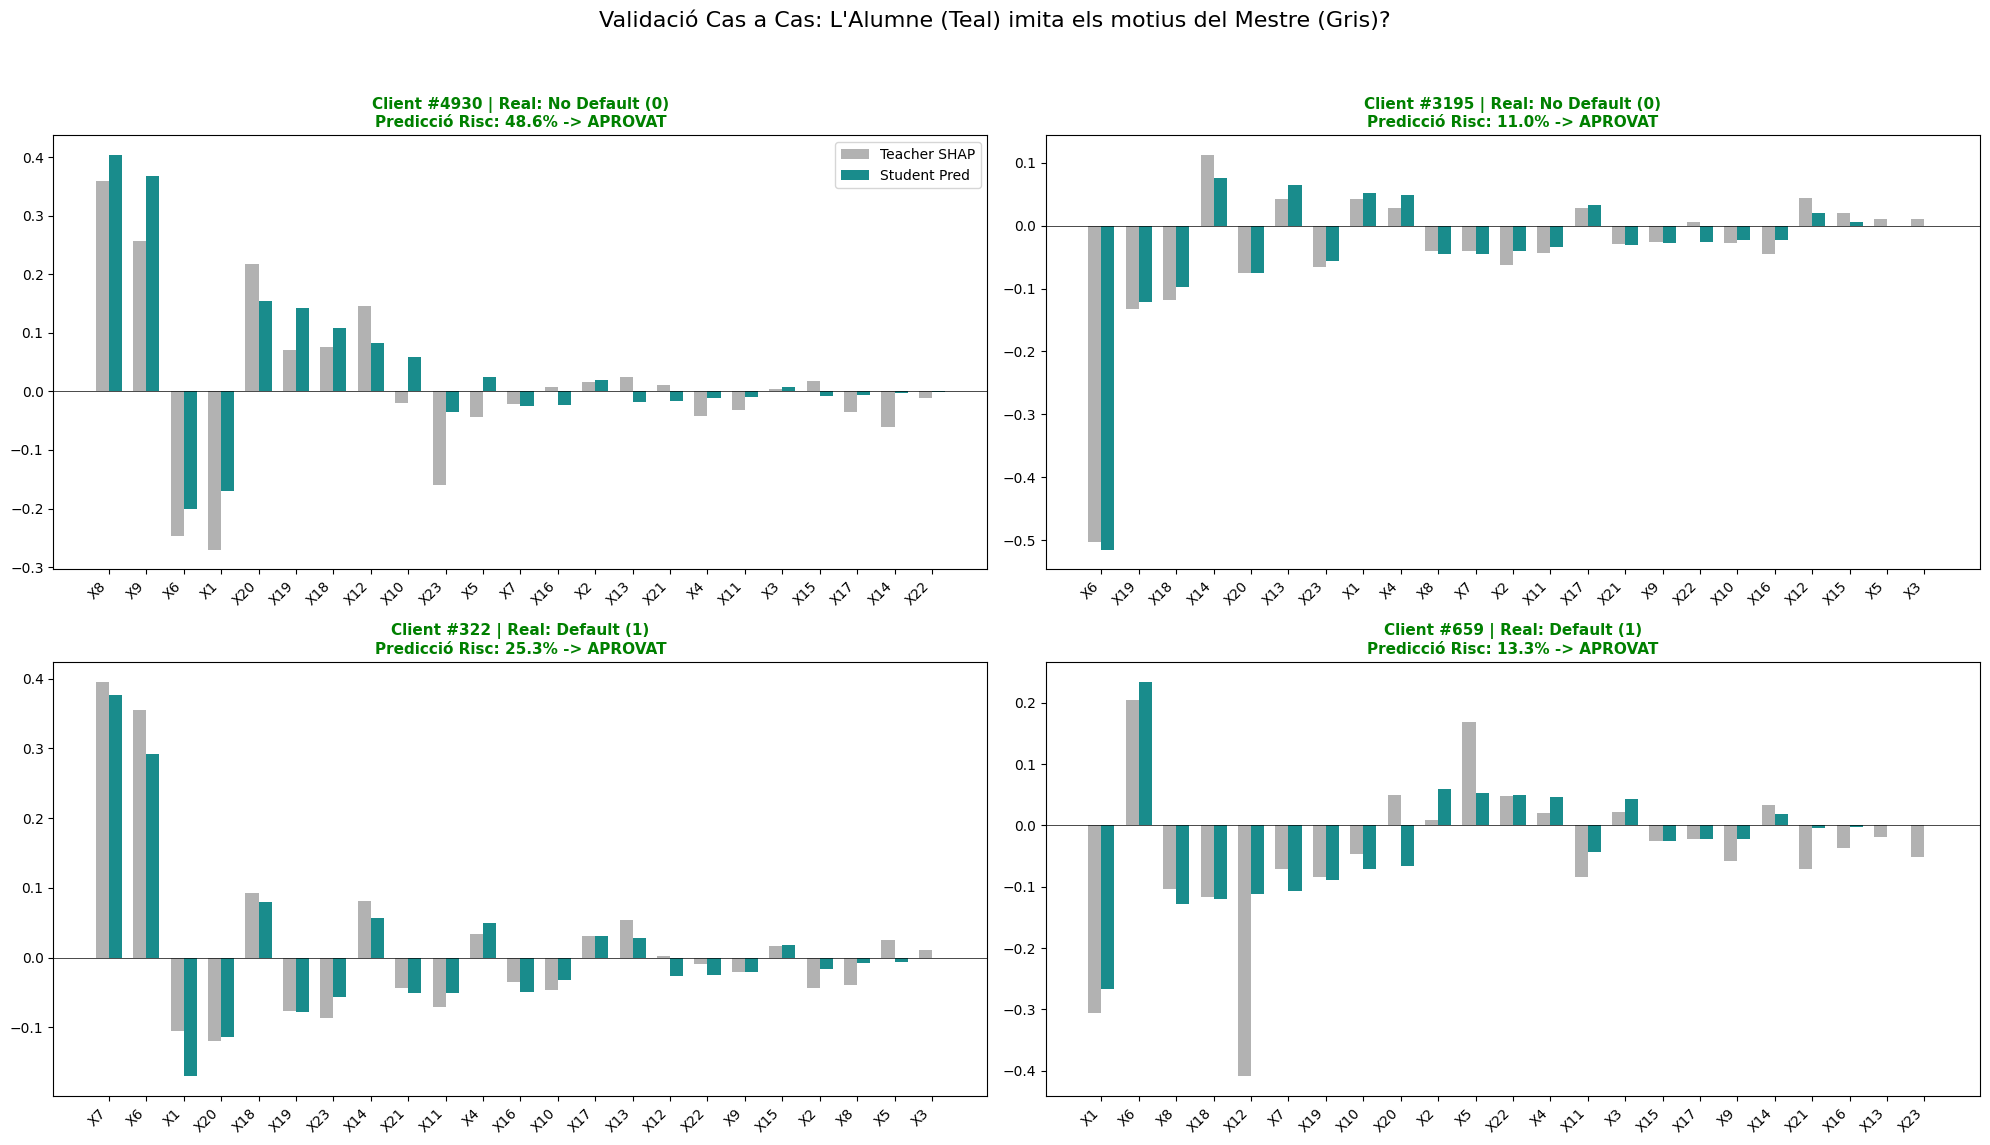

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_student_vs_shap_detailed(student_model, shap_values_test, X_test_scaled, y_test, feature_names):
    print("\nGENERANT PERFILS DE CLIENTS: STUDENT VS SHAP (Ground Truth)")
    print("=" * 60)
    
    # 1. Selecció aleatòria d'índexs (2 de y=0, 2 de y=1)
    np.random.seed(42) # Per reproductibilitat
    # Busquem índexs on y_test == 0
    pool_0 = np.where(y_test == 0)[0]
    # Busquem índexs on y_test == 1
    pool_1 = np.where(y_test == 1)[0]
    
    # Triem 2 de cada sense repetició
    idx_0 = np.random.choice(pool_0, 2, replace=False)
    idx_1 = np.random.choice(pool_1, 2, replace=False)
    
    # Llista final d'índexs a visualitzar
    selected_indices = np.concatenate([idx_0, idx_1])
    
    # Configuració del plot (2 files x 2 columnes)
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()
    
    # Iterem sobre els 4 clients
    for i, idx in enumerate(selected_indices):
        ax = axes[i]
        
        # A. Dades del client
        x_in = torch.tensor(X_test_scaled[idx:idx+1]).float()
        y_real = int(y_test[idx])
        label_text = "No Default (0)" if y_real == 0 else "Default (1)"
        
        # B. Inferència Student
        with torch.no_grad():
            risk_score, shap_student = student_model(x_in)
        
        risk = risk_score.item()
        vals_student = shap_student.numpy().flatten()
        
        # C. Ground Truth SHAP (del Teacher)
        # Recorda: shap_values_test ja el tenim calculat d'abans
        vals_teacher = shap_values_test[idx]
        
        # D. Decisió del Model
        decision = "DENEGAT" if risk > 0.5 else "APROVAT"
        color_dec = "red" if risk > 0.5 else "green"
        
        # E. Preparació del Gràfic
        # Ordenem per magnitud del STUDENT per veure les seves prioritats
        top_k = 23 
        sorted_idx = np.argsort(np.abs(vals_student))[::-1][:top_k]
        
        # Posicions de les barres
        x_pos = np.arange(top_k)
        width = 0.35
        
        # Dibuixem barres agrupades
        # Barra Grisa = Mestre (Veritat)
        # Barra Teal = Alumne (Predicció)
        ax.bar(x_pos - width/2, vals_teacher[sorted_idx], width, label='Teacher SHAP', color='gray', alpha=0.6)
        ax.bar(x_pos + width/2, vals_student[sorted_idx], width, label='Student Pred', color='teal', alpha=0.9)
        
        # Etiquetes i Títols
        ax.set_xticks(x_pos)
        ax.set_xticklabels(np.array(feature_names)[sorted_idx], rotation=45, ha='right')
        ax.axhline(0, color='black', linewidth=0.5)
        
        title = f"Client #{idx} | Real: {label_text}\nPredicció Risc: {risk:.1%} -> {decision}"
        ax.set_title(title, fontsize=11, fontweight='bold', color=color_dec)
        
        if i == 0: ax.legend() # Llegenda només al primer

    plt.suptitle("Validació Cas a Cas: L'Alumne (Teal) imita els motius del Mestre (Gris)?", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Execució
# Assegura't de passar 'shap_values_test' que vas calcular a la Cel·la 3
plot_student_vs_shap_detailed(student, shap_values_test, X_test_scaled, y_test, list(dataset.data.features.columns))